# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


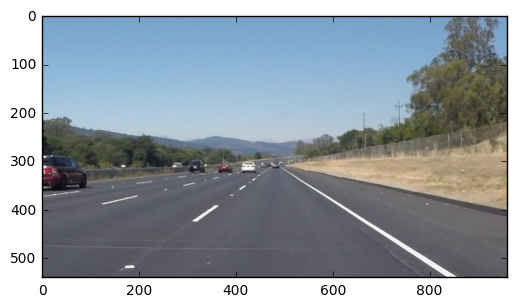

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def color_select(image,threshold_r,threshold_g,threshold_b):
# Use a "bitwise OR" to identify pixels below the threshold
  thresholds = (image[:,:,0] < threshold_r) \
            | (image[:,:,1] < threshold_g) \
            | (image[:,:,2] < threshold_b)
  filtered = image.copy()
  filtered[thresholds] = [0,0,0]
  return filtered




## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
from operator import itemgetter

#extract the lower center part of the image
def filterAreaOfInterest(image):
    maxx = image.shape[1]
    maxy = image.shape[0]
    y1 = int(maxy)
    y2 = int(maxy*0.6)
    x1 = int(maxx*0.4)
    x2 = int(maxx*0.6)
    x3 = int(maxx)
    area = np.array([[0,y1],[x1,y2],[x2,y2],[x3,y1]])
   
    return region_of_interest(image,[area])

#filter colors exeeding a statistical criteria
def filterImage(image):
    
  filtered_image = color_select(image,175,175,35)
  return filtered_image

#filter and average lines, add slope and offset
def averageLines(lines,max_delta_m, max_delta_b, max_delta_dist):
  av1_lines=[]
  av2_lines=[]
  for i in range(lines.shape[0]):
    for x1,y1,x2,y2 in lines[i]:
    
      if x2 -x1 == 0:
        continue
        
      #filter short lines
      l = (x2 -x1)*(x2 -x1) + (y2 - y1)*(y2 - y1)
      if l < 200:
        continue
    
      m1 = (y2 -y1) / (x2 -x1)
      if m1 == 0:
        m1 = 0.0001
        
      b1 = y1 - x1*m1
    
      #filter unrelistic angle to drive 
      if m1 > 0 and (m1 < 0.3 or  m1 > 2):
        continue
      elif m1 < 0 and (m1 > (-0.3) or  m1 < (-2)):
        continue
                     
      # sort coordinates
      if x2 > x1:
        av1_lines.append((m1,b1,x1,y1,x2,y2))  
      else:
        av1_lines.append((m1,b1,x2,y2,x1,y1))  
        
  for i in range(len(av1_lines)):    
    (m1,b1,x11,y11,x12,y12) = av1_lines[i]
    if x11 == 0 and x12 == 0:
      continue
    av_lines=[]
    av_lines.append((m1,b1,x11,y11,x12,y12))  

    for j in range(len(av1_lines)-1, i, -1):
      (m2,b2,x21,y21,x22,y22) = av1_lines[j]
      if x21 == 0 and x22 == 0:
        continue
        
# distance between begin point and and point of two lines  
      dist = (x21 - x12)*(x21 - x12) + (y21 - y12)*(y21 - y12)
            
# apply average conditions
      if (abs(math.atan(m1) - math.atan(m2)) > max_delta_m) or (abs(b1 - b2) > max_delta_b) or dist > max_delta_dist:
        continue
        
      av_lines.append((m2,b2,x21,y21,x22,y22))  
# mark the line not to be used again  
      av1_lines[j] = (0,0,0,0,0,0)
#      print("merge ",j, " to ",i)

    if len(av_lines) > 1:
#mean for slope and offset
      av = np.mean(av_lines,axis=0)       
#min y for end of lane coordinate, 
      avmin = np.min(av_lines,axis=0)       
#max y for bottom line      
      avmax = np.max(av_lines,axis=0)       
      m = av[0]
      if m == 0:
        continue
        
      b = av[1]       

      x0 = avmin[2]        
      y0 = int(x0*m + b)      
    
      x1 = avmax[4]        
      y1 = int(x1*m + b)      
       
      av_line = (m,b,int(x0),int(y0),int(x1),int(y1))
      av2_lines.append(av_line)
    else:
      av2_lines.append(av_lines[0])    
    
  return av2_lines

#extend a line to the bottom ( max y value)
def extendToBotton(line, maxy):
  (m,b,x1,y1,x2,y2) = line
  yb = maxy
  xb = (yb - b) / m
  if y1 < y2:
    return (m,b,x1,y1,int(xb),yb)
  else:
    return (m,b,int(xb),yb,x2,y2)

      
#select the first left and the last right and extend them  down to the bottom
def extendLines(lines, maxy,maxx):
  ext_lines = []
  for i in range(len(lines)):
#    print(lines[i])  
    (m,b,x1,y1,x2,y2) = lines[i]
    yb = maxy
    xb = (yb - b) / m
                       
    line = (m,b,int(x1),int(y1),x2,y2)
    ext_lines.append(line)

#sort for the x at bottom and find a left and a right line close to the center
  left_line = None
  right_line = None
  ls = sorted(ext_lines,key=itemgetter(2))
    
  for line in ls:
    (m,b,x1,y1,x2,y2) = line
    #left start in the left half and end close to the middle
    if m < 0 and x1 < maxx*0.5 and x2 < maxx*0.6 and left_line == None:
      left_line = line
    #right starts in the right half and end close to the middle
    elif m > 0 and x1 > maxx*0.5 and x2 > maxx*0.4:
      right_line = line
#    else:
#      print("skipped:",line)
  
  ext2_lines = []
  if left_line != None:
    ext2_lines.append(extendToBotton(left_line,maxy))
  if right_line != None:
    ext2_lines.append(extendToBotton(right_line,maxy))
    
  return ext2_lines

#for logging bad situations
def saveImageAndReturn(image, name, image_counter):
  fig = plt.gcf()
  plt.imshow(image)
  imageName = "{0}{1}".format(name,image_counter)
  fig.savefig(imageName) 
  print("stored image:",imageName)
  return image       

#draw lines
def drawLines(lines,lines_img):
    for line in lines:
      (m,b,x1,y1,x2,y2) = line
      cv2.line(lines_img, (x1,y1), (x2,y2), [255,0,0], 15)
    

['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve2.jpg', 'solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']
solidWhiteCurve.jpg


/home/frank/.conda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:46: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


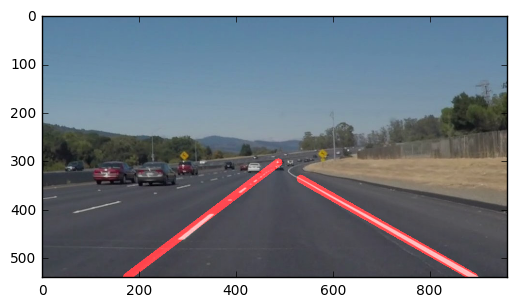

solidWhiteRight.jpg


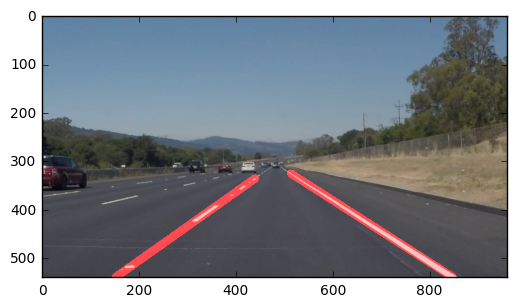

solidYellowCurve2.jpg


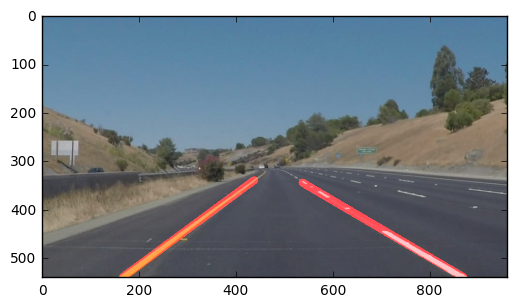

solidYellowCurve.jpg


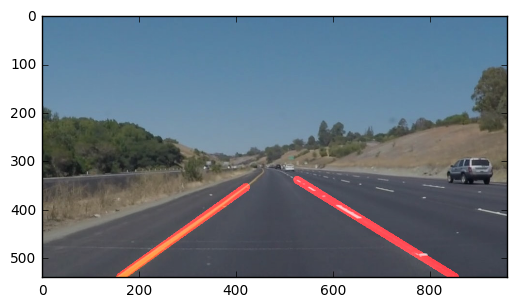

solidYellowLeft.jpg
stored image: notTwoExtendedLines1


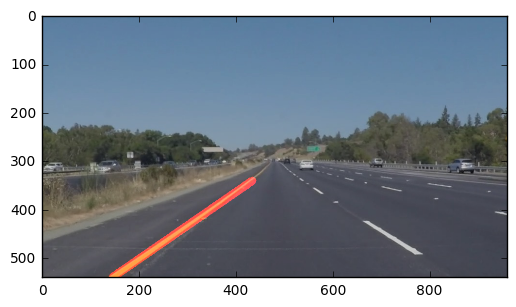

whiteCarLaneSwitch.jpg
stored image: notTwoExtendedLines2


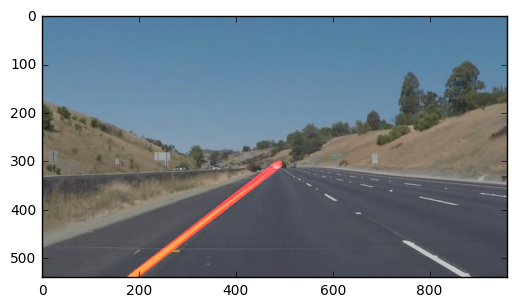

In [9]:
import os
print(os.listdir("test_images/"))

global bad_image_counter
bad_image_counter=0

#the process chain to draw lane lines on the road
def process_colored_image(image):
  global bad_image_counter

# apply an area of interest
  area_filtered_image = filterAreaOfInterest(image)

#  apply a color statistical filter
  filtered_image = filterImage(area_filtered_image)
    
# move to gray shaded
  gray = grayscale(filtered_image)

# define a kernel size and apply Gaussian smoothing
  kernel_size = 9
  blur_gray = gaussian_blur(gray,kernel_size).copy()

# define our parameters for Canny and apply
  low_threshold = 200
  high_threshold = 255
  edges = canny(blur_gray, low_threshold, high_threshold).copy()

# define the Hough transform parameters
  rho = 1
  theta = np.pi/180
  threshold = 30
  min_line_length = 100
  max_line_gap = 250

# define parameters for avering. max difference in slope and offest intwo steps
  delta_m1 = 0.03
  delta_b1 = 20
  delta_dist = 999999999#not used

# Run Hough on edge detected image, if nothing is detected reduce line length
  lines_img = np.zeros((*edges.shape, 3), dtype=np.uint8)
  lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), minLineLength=min_line_length, maxLineGap=max_line_gap)

#first step avering of lines    
  if lines == None:
    bad_image_counter +=1
    return saveImageAndReturn(filtered_image, "noLines", bad_image_counter)

#  draw_lines(lines_img,lines)
  lines = averageLines(lines,delta_m1,delta_b1, delta_dist)

  if len(lines) < 2:
    bad_image_counter +=1
    drawLines(lines,lines_img)
    result = weighted_img(lines_img, image)
    return saveImageAndReturn(result, "notTwoLines", bad_image_counter)

#extend lines and select a left and a right line
  lines = extendLines(lines,lines_img.shape[0], lines_img.shape[1])
    
  drawLines(lines,lines_img)
  result = weighted_img(lines_img, image)
  if len(lines) < 2:
    bad_image_counter +=1
    return saveImageAndReturn(result, "notTwoExtendedLines", bad_image_counter)
    
  return result

#loop over the test pictures
resultPath = "result_images/"
if not os.path.exists(resultPath):
  os.mkdir(resultPath)

for item in os.listdir("test_images/"):
  #Read in and grayscale the image
  print(item)
  path_to_image = os.path.join("test_images",item)
  image = mpimg.imread(path_to_image)    
    
  result = process_colored_image(image)
  path_to_result = os.path.join(resultPath,"result_{0}".format(item))
  fig = plt.gcf()
  plt.imshow(result)
  fig.savefig(path_to_result) 
  plt.show()

  


run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    

    return process_colored_image(image)

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("P1_example.mp4"))

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


There are three major weaknesses of the current implementation:

1. thresholds for color filtering of the image are not fitting to all environments. 
   Even I have taken a statistic, the challange video shows, that its not too robust to shadows.
   An improvement would statistic based on horizontal cuts in the lower area to identify color
   distribution in the relevant area.
   
2. the thresholds for the HoughLines algorithm are very sensitiv to adjust. 
   If more lines are detected, an additional filter would be required to select the relevant
   lines that reflect the lane lines. I would improve first to create lines only on the lower
   image part and would filter out lines that dont have an range of angle. Something +- 20
   degrees around 50 degrees on the left side and 120 degrees on the right side.
   For the challenge I tried a recursive approach to relax parameters, if line detection shows 
   bad results. a more sophisticated design would clearly improve.
   
3. The averaged lane line segments in curves result in lines that do not fit to the real lane
   lines. Averaging is as well very sensitiv. Either lines are averaged, which do not belonge
   together or averaging excludes neihbors. As well a more dynamic fit of the thresholds could
   help.
  
Update after 1. review
1. I removed the statistical approach for color thresholds, it did not work very well. The fixed color values work better
2. I followed the review and changed threshold and parameters for HoughLines algorithm. It  stabilized the behaviour
3. I introduced a check for line availabilty. I flines are not found the image is saved for a drill down. 
in the white and the yellow video ineach frame lines are created
4. I introduced an angle filter to avoid a vertical line in video yellow or extra video.


  

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))